In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import wilcoxon, shapiro
from matplotlib.lines import Line2D

load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')
true_landamarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')

CNN_full_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_full_augmenatation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

CNN_no_blur_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_no_blur_augmentation.npy')
UNET_no_blur_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_no_blur_augmentation.npy')

CNN_no_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_no_augmentation.npy')
UNET_no_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_no_augmentation.npy')

In [ ]:
print(images.shape)
print(true_landamarks.shape)

print(CNN_full_augmentation.shape)
print(UNET_full_augmenatation.shape)
print(CNN_no_blur_augmentation.shape)
print(UNET_no_blur_augmentation.shape)
print(CNN_no_augmentation.shape)
print(UNET_no_augmentation.shape)

(987, 160, 320, 3)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)


calculate error

In [ ]:
height, width = 160, 320

def landmark_error(y_true, y_pred, width, height):
    y_true_dn = y_true.copy()
    y_pred_dn = y_pred.copy()
    y_true_dn[:, :, 0] *= width
    y_true_dn[:, :, 1] *= height
    y_pred_dn[:, :, 0] *= width
    y_pred_dn[:, :, 1] *= height
    return np.sqrt(((y_true_dn - y_pred_dn)**2).sum(axis=2)).mean(axis=1)

errors_CNN_full = landmark_error(true_landamarks, CNN_full_augmentation, width, height)
errors_UNET_full = landmark_error(true_landamarks, UNET_full_augmenatation, width, height)

errors_CNN_no_blur = landmark_error(true_landamarks, CNN_no_blur_augmentation, width, height)
errors_UNET_no_blur = landmark_error(true_landamarks, UNET_no_blur_augmentation, width, height)

errors_CNN_none = landmark_error(true_landamarks, CNN_no_augmentation, width, height)
errors_UNET_none = landmark_error(true_landamarks, UNET_no_augmentation, width, height)

plot

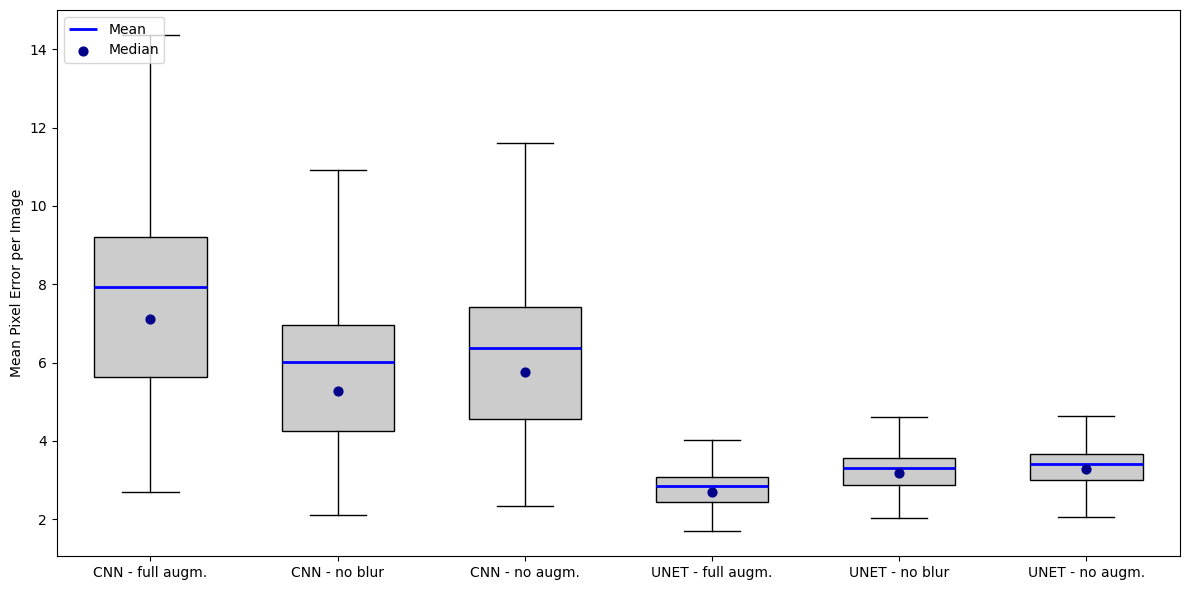

In [ ]:
height, width = 160, 320

# error array
errors_list = [errors_CNN_full, errors_CNN_no_blur, errors_CNN_none, errors_UNET_full, errors_UNET_no_blur, errors_UNET_none]

labels = ["CNN - full augm.", "CNN - no blur", "CNN - no augm.", "UNET - full augm.", "UNET - no blur", "UNET - no augm."]

fig, ax = plt.subplots(figsize=(12,6))

# boxplots without outliers
box = ax.boxplot(
    errors_list,
    patch_artist=True,
    widths=0.6,
    showfliers=False,
    medianprops=dict(color='white', linewidth=0)
)

# grey
for patch in box['boxes']:
    patch.set_facecolor('#CCCCCC')

# mean line
for i, d in enumerate(errors_list):
    mean_val = np.mean(d)
    x_left = i + 1 - 0.3
    x_right = i + 1 + 0.3
    ax.hlines(mean_val, x_left, x_right, color='blue', linewidth=2, label='Mean' if i==0 else "")

# median dot
for i, d in enumerate(errors_list):
    median_val = np.median(d)
    ax.scatter(i+1, median_val, color='darkblue', s=40, zorder=3, label='Median' if i==0 else "")

ax.set_xticklabels(labels)
ax.set_ylabel('Mean Pixel Error per Image')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

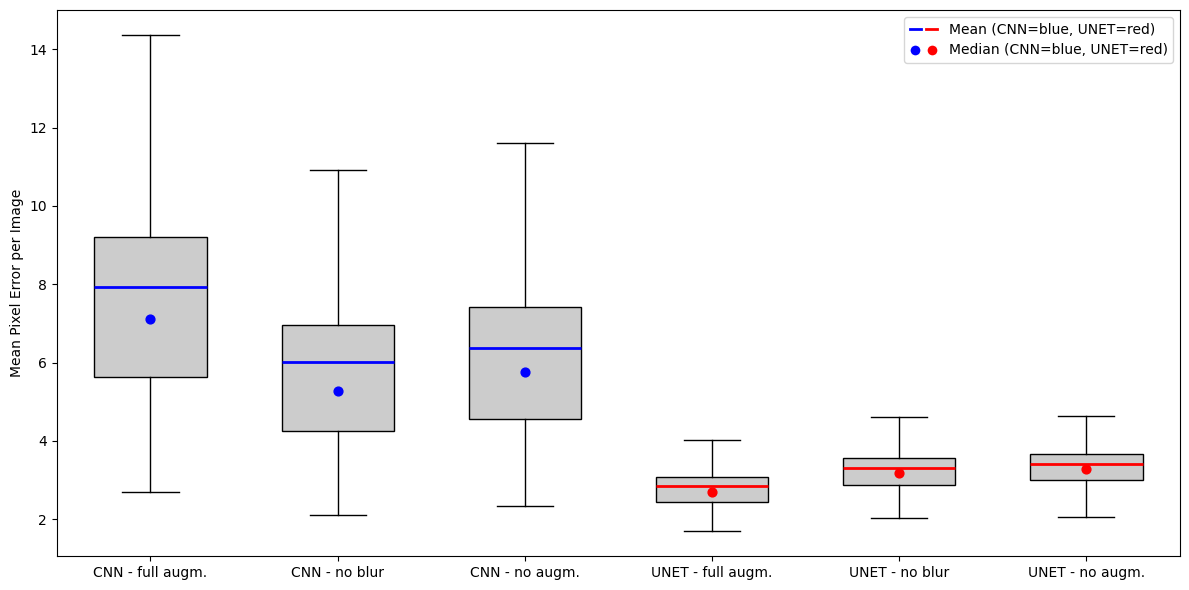

In [ ]:
height, width = 160, 320

# error arrays
errors_list = [
    errors_CNN_full, errors_CNN_no_blur, errors_CNN_none,
    errors_UNET_full, errors_UNET_no_blur, errors_UNET_none
]

labels = [
    "CNN - full augm.", "CNN - no blur", "CNN - no augm.",
    "UNET - full augm.", "UNET - no blur", "UNET - no augm."
]

fig, ax = plt.subplots(figsize=(12,6))

# boxplots without outliers
box = ax.boxplot(
    errors_list,
    patch_artist=True,
    widths=0.6,
    showfliers=False,
    medianprops=dict(color='white', linewidth=0)
)

# box grey
for patch in box['boxes']:
    patch.set_facecolor('#CCCCCC')

# color per model
colors = ['blue', 'blue', 'blue', 'red', 'red', 'red']

# mean line and median dot
for i, (d, c) in enumerate(zip(errors_list, colors)):
    mean_val = np.mean(d)
    median_val = np.median(d)

    # mean line
    ax.hlines(mean_val, i+1-0.3, i+1+0.3, color=c, linewidth=2)

    # median dot
    ax.scatter(i+1, median_val, color=c, s=40, zorder=3)

# combined legend
# custom line (blue and red)
mean_handle = Line2D([0], [0], color='blue', linewidth=2)
mean_handle_red = Line2D([0], [0], color='red', linewidth=2)

# custom scatter (blue and red)
median_handle = Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='blue', markersize=8)
median_handle_red = Line2D([0], [0], marker='o', color='w',
                           markerfacecolor='red', markersize=8)

# legend two elements, mix
ax.legend(
    handles=[(mean_handle, mean_handle_red), (median_handle, median_handle_red)],
    labels=['Mean (CNN=blue, UNET=red)', 'Median (CNN=blue, UNET=red)'],
    handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)},
    loc='upper right')

# axis
ax.set_xticklabels(labels)
ax.set_ylabel('Mean Pixel Error per Image')

plt.tight_layout()
plt.show()

value table

In [ ]:
stats = []
for label, d in zip(labels, errors_list):
    stats.append({
        "Model": label,
        "Mean ± SD": f"{np.mean(d):.2f} ± {np.std(d):.2f}",
        "Median": f"{np.median(d):.2f}"
    })

df_stats = pd.DataFrame(stats)

In [ ]:
df_stats.head(6)

,Model,Mean ± SD,Median
0,CNN - full augm.,7.94 ± 3.92,7.12
1,CNN - no blur,6.00 ± 3.36,5.28
2,CNN - no augm.,6.36 ± 3.18,5.76
3,UNET - full augm.,2.85 ± 0.97,2.69
4,UNET - no blur,3.31 ± 0.88,3.19
5,UNET - no augm.,3.41 ± 0.74,3.29


proove statistically

In [ ]:
# pairs for comparison
pairs = [
    ("CNN", "Full vs No Blur", errors_CNN_full, errors_CNN_no_blur),
    ("CNN", "Full vs No Augmentation", errors_CNN_full, errors_CNN_none),
    ("CNN", "No Blur vs No Augmentation", errors_CNN_no_blur, errors_CNN_none),
    ("UNET", "Full vs No Blur", errors_UNET_full, errors_UNET_no_blur),
    ("UNET", "Full vs No Augmentation", errors_UNET_full, errors_UNET_no_blur),
    ("UNET", "No Blur vs No Augmentation", errors_UNET_no_blur, errors_UNET_none)]

results = []

for model, desc, group1, group2 in pairs:
    diff = group1 - group2
    shapiro_stat, shapiro_p = shapiro(diff)

    normality = "Yes" if shapiro_p > 0.05 else "No"

    # wilcoxon
    stat, p_val = wilcoxon(group1, group2)

    # effect size r
    n = len(group1)
    z = (stat - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)  # Approximierter z-Wert
    r = abs(z) / np.sqrt(n)

    results.append({
        "Model": model,
        "Comparison": desc,
        "Shapiro-Wilk stat": round(shapiro_stat, 6),
        "Shapiro-Wilk p-value": round(shapiro_p, 6),
        "Normal?": normality,
        "Wilcoxon stat": stat,
        "Wilcoxon p-value": round(p_val, 10),
        "Effect size r": round(r, 4)})

df_results = pd.DataFrame(results)

In [ ]:
df_results.head(6)

,Model,Comparison,Shapiro-Wilk stat,Shapiro-Wilk p-value,Normal?,Wilcoxon stat,Wilcoxon p-value,Effect size r
0,CNN,Full vs No Blur,0.842282,0.0,No,33758.0,0.000000e+00,0.7463
1,CNN,Full vs No Augmentation,0.768290,0.0,No,78927.0,0.000000e+00,0.5858
2,CNN,No Blur vs No Augmentation,0.649106,0.0,No,176172.0,0.000000e+00,0.2403
3,UNET,Full vs No Blur,0.775412,0.0,No,50353.0,0.000000e+00,0.6873
4,UNET,Full vs No Augmentation,0.775412,0.0,No,50353.0,0.000000e+00,0.6873
5,UNET,No Blur vs No Augmentation,0.798343,0.0,No,187429.0,3.000000e-10,0.2003


In [ ]:
# error array per model

# CNN
errors_CNN_dict = {'Full': errors_CNN_full, 'No Blur': errors_CNN_no_blur, 'No Aug': errors_CNN_none}

# UNET
errors_UNET_dict = {'Full': errors_UNET_full, 'No Blur': errors_UNET_no_blur, 'No Aug': errors_UNET_none}

# wilcoson rank
def pairwise_wilcoxon(errors_dict):
    variants = list(errors_dict.keys())
    p_matrix = pd.DataFrame(np.nan, index=variants, columns=variants)

    for i, v1 in enumerate(variants):
        for j, v2 in enumerate(variants):
            if i < j:
                stat, p = wilcoxon(errors_dict[v1], errors_dict[v2])
                p_matrix.loc[v1, v2] = p
            elif i > j:
                p_matrix.loc[v1, v2] = p_matrix.loc[v2, v1]
            else:
                p_matrix.loc[v1, v2] = np.nan
    return p_matrix

# CNN
pvals_CNN = pairwise_wilcoxon(errors_CNN_dict)

# UNET
pvals_UNET = pairwise_wilcoxon(errors_UNET_dict)

CNN pairwise Wilcoxon signed-rank p-values:
                  Full        No Blur        No Aug
Full               NaN  1.452760e-121  1.226514e-75
No Blur  1.452760e-121            NaN  4.414608e-14
No Aug    1.226514e-75   4.414608e-14           NaN

UNET pairwise Wilcoxon signed-rank p-values:
                  Full        No Blur         No Aug
Full               NaN  2.069065e-103  1.200597e-120
No Blur  2.069065e-103            NaN   3.143598e-10
No Aug   1.200597e-120   3.143598e-10            NaN


In [ ]:
pvals_CNN.head()

,Full,No Blur,No Aug
Full,NaN,1.452760e-121,1.226514e-75
No Blur,1.452760e-121,NaN,4.414608e-14
No Aug,1.226514e-75,4.414608e-14,NaN


In [ ]:
pvals_UNET.head()

,Full,No Blur,No Aug
Full,NaN,2.069065e-103,1.200597e-120
No Blur,2.069065e-103,NaN,3.143598e-10
No Aug,1.200597e-120,3.143598e-10,NaN
